In [1]:
import pandas as pd
import numpy as np
import os
import sys
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import tqdm

In [2]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D
from keras import backend as K
import cv2

import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization, concatenate, AveragePooling2D
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Reshape, Permute
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import GRU, LSTM

In [4]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Input data

In [5]:
PATH_VOL = "/home/ubuntu/data"
PATH_DATA = os.path.join(PATH_VOL, "spec")
PATH_TRIPLETS = os.path.join(PATH_VOL, "triplets.csv")
PATH_NEO = os.path.join(PATH_VOL, "dfneo_CAT.csv")

In [6]:
# Spectogram files
data_files = os.listdir(PATH_DATA)

### Triplets

In [7]:
# Load triplets
df = pd.read_csv(PATH_TRIPLETS, delimiter= ";")

In [8]:
# List
triplets_input = list(df["output"])
size_triplets_input = len(triplets_input)

# Sample
triplets_input_v1 = triplets_input[:1000]
size_triplets_input = len(triplets_input_v1)

# Artists
artists_labels = np.sort(df.a1.unique())
df_artists = pd.DataFrame(data = artists_labels, columns = ["artist"]).reset_index()
df_artists.columns = ["id","artist"]

# DF Artists with artists as index
df_artists_index = df_artists.set_index("artist")
num_artists = df_artists.shape[0]

### Load catalan artists and songs

In [9]:
# Load catalan artists and tracks
dfneo = pd.read_csv(PATH_NEO, sep = ";")

In [10]:
set_art_cat = set()
for ii, row in dfneo.iterrows():
    set_art_cat.add(row["a.artist_id"])
    set_art_cat.add(row["a2.artist_id"])

In [11]:
sel_art = list(set_art_cat)

In [12]:
df_artists_cat = df_artists[df_artists.artist.isin(set_art_cat)]["artist"].reset_index()
df_artists_cat["id"] = df_artists_cat.index
df_artists_cat.drop('index', axis=1, inplace = True)

# Labels

In [13]:
df_artists_gen = df_artists_cat.copy()

In [14]:
labels_mat = keras.utils.to_categorical(df_artists_gen.id)

In [15]:
labels = dict()
for i, row in df_artists_gen.iterrows():
    labels[row.artist] = labels_mat[row.id,].astype(int)

In [16]:
num_artists = len(labels.keys())

## Songs

In [17]:
df_gen = df[df.a1.isin(set_art_cat)]

In [18]:
df1 = df_gen[["a1","tr1","win1","ini1","fin1"]].copy()
df2 = df_gen[["a1","tr2","win2","ini2","fin2"]].copy()

# Column names
colnames = ["art","tr","win","ini","fin"]
df1.columns = colnames
df2.columns = colnames

In [19]:
df_concat = pd.concat([df1, df2])
df_concat.drop_duplicates(inplace = True)

In [20]:
df_concat["tr"] = df_concat.tr + "__" + df_concat.win.astype(str) +  \
    "__" + df_concat.ini.astype(str) + "__" + df_concat.fin.astype(str) + ".jpg"

In [21]:
df_concat = df_concat.reset_index().drop("index", axis = 1)

# Data Generator

In [22]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, scaling, x_col, y_col=None, batch_size=10, num_classes=None, shuffle=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.x_col = x_col
        self.y_col = y_col
        self.dim = (int(x_col / scaling), int(y_col / scaling), 1) #one input channel
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        idx = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in idx]
        
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        pass

    def __get_data(self, batch):
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size, self.num_classes), dtype=int)
        
        # Get the list of image files and corresponding artists
        df_imgs_files = self.df.iloc[batch]
        
        list_imgs = list(df_imgs_files["tr"])
        list_art = list(df_imgs_files["art"])
        
        for ii in range(len(list_imgs)):
            
            # Read image using cv2
            path_img = os.path.join(PATH_DATA, list_imgs[ii])
            img = cv2.cvtColor(cv2.imread(path_img), cv2.COLOR_BGR2GRAY)
            img = np.round(img / 255.,5)
            img = cv2.resize(img, (self.y_col, self.x_col))
            img = cv2.resize(img, (self.dim[1], self.dim[0]))
            img = np.expand_dims(img, axis = 2) # add the dimension of the channel 
            
            # Put it into X matrix
            X[ii,] = img
            y[ii] = labels[list_art[ii]]

        return X, y

In [ ]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, scaling, x_col, y_col=None, batch_size=10, num_classes=None, shuffle=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.x_col = x_col
        self.y_col = y_col
        self.dim = (int(x_col / scaling), int(y_col / scaling), 1) #one input channel
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        idx = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in idx]
        
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        pass

    def __get_data(self, batch):
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size, self.num_classes), dtype=int)
        
        # Get the list of image files and corresponding artists
        df_imgs_files = self.df.iloc[batch]
        
        list_imgs = list(df_imgs_files["tr"])
        list_art = list(df_imgs_files["art"])
        
        for ii in range(len(list_imgs)):
            
            # Read image using cv2
            path_img = os.path.join(PATH_DATA, list_imgs[ii])
            img = cv2.cvtColor(cv2.imread(path_img), cv2.COLOR_BGR2GRAY)
            img = np.round(img / 255.,5)
            img = cv2.resize(img, (self.y_col, self.x_col))
            img = cv2.resize(img, (self.dim[1], self.dim[0]))
            img = np.expand_dims(img, axis = 2) # add the dimension of the channel 
            
            # Put it into X matrix
            X[ii,] = img
            y[ii] = labels[list_art[ii]]

        return X, y

In [64]:
x_col, y_col = (256, 937)
num_classes = df_artists.shape[0]
shuffle = False
scaling = 2
batch_size = 10

training_generator = DataGenerator(df=df_concat, 
                                   scaling = scaling,
                                   x_col=x_col, 
                                   y_col=y_col,
                                   batch_size=batch_size, 
                                   num_classes=num_artists,
                                   shuffle=False)

1915it [01:01, 31.11it/s]


0

# Model

In [35]:
def conv_layer(conv_x, filters):
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_x)
    conv_x = Dropout(0.2)(conv_x)

    return conv_x


def dense_block(block_x, filters, growth_rate, layers_in_block):
    for i in range(layers_in_block):
        each_layer = conv_layer(block_x, growth_rate)
        block_x = concatenate([block_x, each_layer], axis=-1)
        filters += growth_rate

    return block_x, filters

def transition_block(trans_x, tran_filters):
    trans_x = BatchNormalization()(trans_x)
    trans_x = Activation('relu')(trans_x)
    trans_x = Conv2D(tran_filters, (1, 1), kernel_initializer='he_uniform', padding='same', use_bias=False)(trans_x)
    trans_x = AveragePooling2D((2, 2), strides=(2, 2))(trans_x)

    return trans_x, tran_filters

def dense_net(filters, growth_rate, classes, dense_block_size, layers_in_block, in_shape):
    input_img = Input(shape=in_shape)
    x = Conv2D(3, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(input_img)

    dense_x = BatchNormalization()(x)
    dense_x = Activation('relu')(x)

    dense_x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(dense_x)
    for block in range(dense_block_size - 1):
        dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
        dense_x, filters = transition_block(dense_x, filters)

    dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
    dense_x = BatchNormalization()(dense_x)
    dense_x = Activation('relu')(dense_x)
    dense_x = GlobalAveragePooling2D()(dense_x)

    output = Dense(classes, activation='softmax')(dense_x)

    return Model(input_img, output)

In [36]:
def CRNN2D(X_shape, nb_classes):
    '''
    Model used for evaluation in paper. Inspired by K. Choi model in:
    https://github.com/keunwoochoi/music-auto_tagging-keras/blob/master/music_tagger_crnn.py
    '''

    nb_layers = 4  # number of convolutional layers
    nb_filters = [64, 128, 128, 128]  # filter sizes
    kernel_size = (3, 3)  # convolution kernel size
    activation = 'elu'  # activation function to use after each layer
    pool_size = [(2, 2), (4, 2), (4, 2), (4, 2),
                 (4, 2)]  # size of pooling area

    # shape of input data (frequency, time, channels)
    input_shape = X_shape
    frequency_axis = 1
    time_axis = 2
    channel_axis = 3

    # Create sequential model and normalize along frequency axis
    model = Sequential()
    model.add(BatchNormalization(axis=frequency_axis, input_shape=input_shape, trainable = False))

    # First convolution layer specifies shape
    model.add(Conv2D(nb_filters[0], kernel_size=kernel_size, padding='same',
                     data_format="channels_last",
                     input_shape=input_shape))
    model.add(Activation(activation))
    model.add(BatchNormalization(axis=channel_axis, trainable = False))
    model.add(MaxPooling2D(pool_size=pool_size[0], strides=pool_size[0]))
    #model.add(Dropout(0.1))

    # Add more convolutional layers
    for layer in range(nb_layers - 1):
        # Convolutional layer
        model.add(Conv2D(nb_filters[layer + 1], kernel_size=kernel_size,
                         padding='same'))
        model.add(Activation(activation))
        model.add(BatchNormalization(
            axis=channel_axis, trainable = False))  # Improves overfitting/underfitting
        model.add(MaxPooling2D(pool_size=pool_size[layer + 1],
                               strides=pool_size[layer + 1]))  # Max pooling
        #model.add(Dropout(0.1))

        # Reshaping input for recurrent layer
    # (frequency, time, channels) --> (time, frequency, channel)
    model.add(Permute((time_axis, frequency_axis, channel_axis)))
    resize_shape = model.output_shape[2] * model.output_shape[3]
    model.add(Reshape((model.output_shape[1], resize_shape)))

    # recurrent layer
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=False))
    #model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(nb_classes))
    model.add(Activation("softmax"))
    return model


In [67]:
def CRNN2DLarger(X_shape, nb_classes):
    '''
    Making the previous model larger and deeper
    '''
    nb_layers = 5  # number of convolutional layers
    nb_filters = [64, 128, 256, 512, 512]
    kernel_size = (3, 3)  # convolution kernel size
    activation = 'elu'  # activation function to use after each layer
    pool_size = [(2, 2), (2, 2), (2, 2), (4, 1),
                 (4, 1)]  # # size of pooling area
    # pool_size = [(4,2), (4,2), (4,1), (2,1)] this worked well

    # shape of input data (frequency, time, channels)
    input_shape = X_shape
    frequency_axis = 1
    time_axis = 2
    channel_axis = 3

    # Create sequential model
    model = Sequential()
    model.add(BatchNormalization(axis=frequency_axis, input_shape=input_shape))

    # First convolution layer
    model.add(Conv2D(nb_filters[0], kernel_size=kernel_size, padding='same',
                     data_format="channels_last",
                     input_shape=input_shape))
    model.add(Activation(activation))
    model.add(BatchNormalization(
        axis=channel_axis))  # Improves overfitting/underfitting
    model.add(MaxPooling2D(pool_size=pool_size[0],
                           strides=pool_size[0]))  # Max pooling
    model.add(Dropout(0.1))  # 0.2

    # Add more convolutional layers
    for layer in range(nb_layers - 1):
        # Convolutional layer
        model.add(Conv2D(nb_filters[layer + 1], kernel_size=kernel_size,
                         padding='same'))
        model.add(Activation(activation))
        model.add(BatchNormalization(
            axis=channel_axis))  # Improves overfitting/underfitting
        model.add(MaxPooling2D(pool_size=pool_size[layer + 1],
                               strides=pool_size[layer + 1]))  # Max pooling
        model.add(Dropout(0.1))  # 0.2

    # Reshaping input for recurrent layer
    # (frequency, time, channels) --> (time, frequency, channel)
    model.add(Permute((time_axis, frequency_axis, channel_axis)))
    resize_shape = model.output_shape[2] * model.output_shape[3]
    model.add(Reshape((model.output_shape[1], resize_shape)))

    # recurrent layer
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=False))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(nb_classes))
    model.add(Activation("softmax"))
    return model


In [219]:
def CRNN2DLarger_v2(X_shape, nb_classes):
    '''
    Making the previous model larger and deeper
    '''
    nb_layers = 3  # number of convolutional layers
    nb_filters = [32, 64, 128]
    kernel_size = (3, 16)  # convolution kernel size
    activation = 'elu'  # activation function to use after each layer
    pool_size = [(2, 2), (2, 2), (1, 2)]  # # size of pooling area
    # pool_size = [(4,2), (4,2), (4,1), (2,1)] this worked well

    # shape of input data (frequency, time, channels)
    input_shape = X_shape
    frequency_axis = 1
    time_axis = 2
    channel_axis = 3

    # Create sequential model
    model = Sequential()
    model.add(BatchNormalization(axis=frequency_axis, input_shape=input_shape))

    # First convolution layer
    model.add(Conv2D(nb_filters[0], kernel_size=kernel_size, padding='same',
                     data_format="channels_last",
                     input_shape=input_shape))
    model.add(Activation(activation))
    model.add(BatchNormalization(
        axis=channel_axis))  # Improves overfitting/underfitting
    model.add(MaxPooling2D(pool_size=pool_size[0],
                           strides=pool_size[0]))  # Max pooling
    model.add(Dropout(0.1))  # 0.2

    # Add more convolutional layers
    for layer in range(nb_layers - 1):
        # Convolutional layer
        model.add(Conv2D(nb_filters[layer + 1], kernel_size=kernel_size,
                         padding='same'))
        model.add(Activation(activation))
        model.add(BatchNormalization(
            axis=channel_axis))  # Improves overfitting/underfitting
        model.add(MaxPooling2D(pool_size=pool_size[layer + 1],
                               strides=pool_size[layer + 1]))  # Max pooling
        model.add(Dropout(0.1))  # 0.2

    # Reshaping input for recurrent layer
    # (frequency, time, channels) --> (time, frequency, channel)
    model.add(Permute((time_axis, frequency_axis, channel_axis)))
    resize_shape = model.output_shape[2] * model.output_shape[3]
    model.add(Reshape((model.output_shape[1], resize_shape)))

    # recurrent layer
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=False))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(nb_classes))
    model.add(Activation("softmax"))
    return model


In [ ]:
def CRNN2DVGG(X_shape, nb_classes):
    '''
    Based on VGG-16 Architecture
    '''
    nb_layers = 5  # number of convolutional layers
    nb_filters = [64, 128, 256, 512, 512]
    kernel_size = (3, 3)  # convolution kernel size
    activation = 'elu'  # activation function to use after each layer
    pool_size = [(2, 2), (2, 2), (2, 2), (4, 1),
                 (4, 1)]  # # size of pooling area
    # pool_size = [(4,2), (4,2), (4,1), (2,1)] this worked well

    # shape of input data (frequency, time, channels)
    input_shape = X_shape
    frequency_axis = 1
    time_axis = 2
    channel_axis = 3

    # Create sequential model
    model = Sequential()
    model.add(BatchNormalization(axis=frequency_axis, input_shape=input_shape))

    # First convolution layer
    model.add(Conv2D(nb_filters[0], kernel_size=kernel_size, padding='same',
                     data_format="channels_last",
                     input_shape=input_shape))
    model.add(Activation(activation))
    model.add(BatchNormalization(
        axis=channel_axis))  # Improves overfitting/underfitting

    model.add(Conv2D(nb_filters[0], kernel_size=kernel_size, padding='same',
                     data_format="channels_last",
                     input_shape=input_shape))
    model.add(Activation(activation))
    model.add(BatchNormalization(
        axis=channel_axis))  # Improves overfitting/underfitting

    model.add(MaxPooling2D(pool_size=pool_size[0],
                           strides=pool_size[0]))  # Max pooling
    #model.add(Dropout(0.1))  # 0.2

    # Add more convolutional layers
    for layer in range(nb_layers - 1):
        # Convolutional layer
        model.add(Conv2D(nb_filters[layer + 1], kernel_size=kernel_size,
                         padding='same'))
        model.add(Activation(activation))
        model.add(BatchNormalization(
            axis=channel_axis))  # Improves overfitting/underfitting

        model.add(Conv2D(nb_filters[layer + 1], kernel_size=kernel_size,
                         padding='same'))
        model.add(Activation(activation))
        model.add(BatchNormalization(
            axis=channel_axis))  # Improves overfitting/underfitting

        if nb_filters[layer + 1] != 128:
            model.add(Conv2D(nb_filters[layer + 1], kernel_size=kernel_size,
                             padding='same'))
            model.add(Activation(activation))
            model.add(BatchNormalization(
                axis=channel_axis))  # Improves overfitting/underfitting

        model.add(MaxPooling2D(pool_size=pool_size[layer + 1],
                               strides=pool_size[layer + 1]))  # Max pooling
        #model.add(Dropout(0.1))  # 0.2

    # Reshaping input for recurrent layer
    # (frequency, time, channels) --> (time, frequency, channel)
    model.add(Permute((time_axis, frequency_axis, channel_axis)))
    resize_shape = model.output_shape[2] * model.output_shape[3]
    model.add(Reshape((model.output_shape[1], resize_shape)))

    # recurrent layer
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=False))
    #model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(nb_classes))
    model.add(Activation("softmax"))
    return model

In [220]:
def CRNN1D(X_shape, nb_classes):
    '''
    Based on 1D convolution
    '''

    nb_layers = 5  # number of convolutional layers
    kernel_size = 15  # convolution kernel size
    activation = 'relu'  # activation function to use after each layer
    pool_size = 2  # size of pooling area

    # shape of input data (frequency, time, channels)
    input_shape = X_shape
    frequency_axis = 1
    time_axis = 2
    channel_axis = 3

    # Create sequential model
    model = Sequential()

    model.add(Permute((time_axis, frequency_axis, channel_axis),
                      input_shape=input_shape))
    resize_shape = model.output_shape[2] * model.output_shape[3]
    model.add(Reshape((model.output_shape[1], resize_shape)))

    # First convolution layer
    model.add(Conv1D(64, kernel_size))
    model.add(Activation(activation))
    model.add(
        MaxPooling1D(pool_size=pool_size, strides=pool_size))  # Max pooling
    # model.add(Dropout(0.2))

    # Add more convolutional layers
    for _ in range(nb_layers - 1):
        # Convolutional layer
        model.add(Conv1D(128, kernel_size))
        model.add(Activation(activation))
        model.add(MaxPooling1D(pool_size=pool_size,
                               strides=pool_size))  # Max pooling

    model.add(GRU(64, return_sequences=True))
    model.add(GRU(64, return_sequences=False))

    model.add(Dense(nb_classes))  # note sure about this
    model.add(Activation('softmax'))

    # Output layer
    return model

# Simple model

https://github.com/chen0040/keras-audio/blob/master/keras_audio/library/resnet50.py

In [231]:
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, \
    AveragePooling2D, MaxPooling2D

In [232]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('elu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('elu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('elu')(X)

    return X


def identity_block_test():
    tf.reset_default_graph()

    with tf.Session() as test:
        np.random.seed(1)
        A_prev = tf.placeholder("float", [3, 4, 4, 6])
        X = np.random.randn(3, 4, 4, 6)
        A = identity_block(A_prev, f=2, filters=[2, 4, 6], stage=1, block='a')
        test.run(tf.global_variables_initializer())
        out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
        print("out = " + str(out[0][1][1][0]))


def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Implementation of the convolutional block as defined in Figure 4
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First component of main path
    X = Conv2D(F1, (1, 1), padding='valid', strides=(s, s), name=conv_name_base + '2a',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('elu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), padding='same', strides=(1, 1), name=conv_name_base + '2b',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('elu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), padding='valid', strides=(1, 1), name=conv_name_base + '2c',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), padding='valid', strides=(s, s), name=conv_name_base + '1',
                        kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('elu')(X)

    return X


def convolutional_block_test():
    tf.reset_default_graph()

    with tf.Session() as test:
        np.random.seed(1)
        A_prev = tf.placeholder("float", [3, 4, 4, 6])
        X = np.random.randn(3, 4, 4, 6)
        A = convolutional_block(A_prev, f=2, filters=[2, 4, 6], stage=1, block='a')
        test.run(tf.global_variables_initializer())
        out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
        print("out = " + str(out[0][1][1][0]))


def resnet_50(input_shape, classes):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes
    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)

    # X = Dropout(rate=0.25)(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)

    # X = Dense(units=512)(X)
    # X = Activation('elu')(X)

    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [234]:
from keras.initializers import glorot_uniform

# Instantiate the model

In [242]:
#dense_block_size = 4
#layers_in_block = 2

#growth_rate = 2
in_shape = (int(x_col / scaling), int(y_col / scaling), 1)
classes = num_artists

#model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block, in_shape)
#model = quick_CNN2(input_shape=in_shape, num_classes = classes)
#model = CRNN2D(in_shape, classes)
#model = CRNN1D(in_shape, classes)
#model = CRNN2DLarger_v2(in_shape, classes)
#model = keras.models.load_model('models/densenet_v2.tf')
#model = CRNN2DVGG(in_shape, classes)
model = resnet_50(in_shape, classes)

### Train the model

In [243]:
save_metrics_folder='metrics'
save_weights_folder='weights'
load_checkpoint = False
early_stop=10

In [244]:
weights = os.path.join(save_weights_folder, 'ResNet50_v1_epoch_{epoch:02d}.hdf5')
os.makedirs(save_weights_folder, exist_ok=True)
os.makedirs(save_metrics_folder, exist_ok=True)

In [245]:
checkpointer = ModelCheckpoint(filepath=weights,
                                   verbose=1,
                                   save_best_only=False,
                                   save_weights_only=True,
                                   period=10,
                                   monitor = 'loss')
earlystopper = EarlyStopping(monitor='loss', min_delta=0,
                             patience=early_stop, verbose=0, mode='auto')

In [246]:
# training
epochs = 200
lr = 0.001
optimizer = Adam(lr=lr)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [247]:
model.fit_generator(generator = training_generator, 
          epochs=epochs, 
          callbacks=[checkpointer, earlystopper],
          shuffle=True)

Epoch 1/200
191/191 [==============================] - 50s 262ms/step - loss: 15.9577 - accuracy: 0.0377
Epoch 2/200
191/191 [==============================] - 23s 120ms/step - loss: 3.5903 - accuracy: 0.0518
Epoch 3/200
191/191 [==============================] - 23s 119ms/step - loss: 3.3149 - accuracy: 0.0728
Epoch 4/200
191/191 [==============================] - 23s 119ms/step - loss: 3.2567 - accuracy: 0.0984
Epoch 5/200
191/191 [==============================] - 23s 119ms/step - loss: 3.2530 - accuracy: 0.0921
Epoch 6/200
191/191 [==============================] - 23s 119ms/step - loss: 3.0137 - accuracy: 0.1419
Epoch 7/200
191/191 [==============================] - 23s 118ms/step - loss: 2.9233 - accuracy: 0.1382
Epoch 8/200
191/191 [==============================] - 23s 118ms/step - loss: 2.7709 - accuracy: 0.1670
Epoch 9/200
191/191 [==============================] - 22s 118ms/step - loss: 2.8747 - accuracy: 0.1382
Epoch 10/200
191/191 [==============================] - 22s 118

191/191 [==============================] - 22s 117ms/step - loss: 0.1943 - accuracy: 0.9665
Epoch 75/200
191/191 [==============================] - 22s 117ms/step - loss: 0.1466 - accuracy: 0.9738
Epoch 76/200
191/191 [==============================] - 22s 117ms/step - loss: 0.0855 - accuracy: 0.9843
Epoch 77/200
191/191 [==============================] - 23s 118ms/step - loss: 0.0758 - accuracy: 0.9801
Epoch 78/200
191/191 [==============================] - 23s 118ms/step - loss: 0.1601 - accuracy: 0.9691
Epoch 79/200
191/191 [==============================] - 23s 119ms/step - loss: 0.1583 - accuracy: 0.9576
Epoch 80/200
191/191 [==============================] - 23s 118ms/step - loss: 0.4062 - accuracy: 0.9209

Epoch 00080: saving model to weights/ResNet50_v1_epoch_80.hdf5
Epoch 81/200
191/191 [==============================] - 23s 118ms/step - loss: 1.7656 - accuracy: 0.7529
Epoch 82/200
191/191 [==============================] - 23s 118ms/step - loss: 0.6540 - accuracy: 0.8723
Epoc

In [43]:
#model.load_weights("weights/crnn_v5_epoch_50.hdf5")

In [248]:
model.save("models/resnet50.tf")

In [249]:
model.evaluate(training_generator)

191/191 [==============================] - 14s 72ms/step


[0.3601853549480438, 0.7099476456642151]

## Quick prediction

In [250]:
sample, lab = training_generator[1]

pred = model.predict(sample)

class_prediction = np.argmax(pred, axis=1)

In [251]:
list(class_prediction)

[0, 0, 2, 0, 0, 0, 0, 0, 0, 0]

In [252]:
lab

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

## Predict all songs labels

In [253]:
def get_img_predict(img, art, x_col, y_col, scaling):
    path_img = os.path.join(PATH_DATA, img)
    img = cv2.cvtColor(cv2.imread(path_img), cv2.COLOR_BGR2GRAY)
    img = np.round(img / 255.,5)
    dim = (int(x_col / scaling), int(y_col / scaling), 1) #one input channel
    img = cv2.resize(img, (y_col, x_col))
    img = cv2.resize(img, (dim[1], dim[0]))
    img = np.expand_dims(img, axis = 2) # add the dimension of the channel 
    img = np.expand_dims(img, axis = 0)
    return img, labels[art]

In [254]:
dict_pred = defaultdict(dict)

for _, row in tqdm.tqdm(df_concat.iterrows()):
    art, img, win, ini, fin = row
    
    # Get the image and the artist id
    img_matrix, label_real = get_img_predict(img, art, x_col, y_col, scaling)
    
    # Get the predictions
    predictions = model.predict(img_matrix)
    
    # Get the position of the label
    position_label_pred = np.argmax(predictions)
    position_label_real = np.argmax(label_real)
    
    # True prediction
    true_pred = 1 if position_label_pred == position_label_real else 0
    
    # Store in dictionary
    dict_pred[art][win] = dict()
    dict_pred[art][win]["true_pred"] = true_pred
    dict_pred[art][win]["position_label_real"] = position_label_real
    dict_pred[art][win]["position_label_pred"] = position_label_pred
    dict_pred[art][win]["predictions"] = predictions
    dict_pred[art][win]["label_real"] = label_real    

1915it [00:43, 44.10it/s]


In [255]:
df_concat.head()

,art,tr,win,ini,fin
0,0InCPtI0kadS7s3cZrcbbY,3mUonXr6ECjJs2XPDYxWhG__10__192__222.jpg,10,192,222
1,0InCPtI0kadS7s3cZrcbbY,3mUonXr6ECjJs2XPDYxWhG__2__40__70.jpg,2,40,70
2,0InCPtI0kadS7s3cZrcbbY,3mUonXr6ECjJs2XPDYxWhG__9__180__210.jpg,9,180,210
3,0InCPtI0kadS7s3cZrcbbY,3mUonXr6ECjJs2XPDYxWhG__3__60__90.jpg,3,60,90
4,0InCPtI0kadS7s3cZrcbbY,3mUonXr6ECjJs2XPDYxWhG__4__80__110.jpg,4,80,110


In [256]:
list_true_pred = list()
art = "0InCPtI0kadS7s3cZrcbbY"
for ww in dict_pred[art]:
    list_true_pred.append(dict_pred[art][ww]["true_pred"])

In [257]:
sum(list_true_pred) / len(list_true_pred)

0.5833333333333334

# Representation

In [258]:
import copy

In [259]:
embed_model = copy.copy(model)

In [262]:
embed_model.layers.pop()

In [264]:
#embed_model.pop()
#embed_model.pop()

AttributeError: 'Model' object has no attribute 'pop'

In [265]:
dict_pred = defaultdict(dict)

for _, row in tqdm.tqdm(df_concat.iterrows()):
    art, img, win, ini, fin = row
    
    # Get the image and the artist id
    img_matrix, label_real = get_img_predict(img, art, x_col, y_col, scaling)
    
    # Get the predictions
    predictions = model.predict(img_matrix)
    
    # Get the position of the label
    position_label_pred = np.argmax(predictions)
    position_label_real = np.argmax(label_real)
    
    # True prediction
    true_pred = 1 if position_label_pred == position_label_real else 0
    
    # Compute the embedding
    embedding = embed_model.predict(img_matrix)
    
    # Store in dictionary
    dict_pred[art][img] = dict()
    dict_pred[art][img]["true_pred"] = true_pred
    dict_pred[art][img]["position_label_real"] = position_label_real
    dict_pred[art][img]["position_label_pred"] = position_label_pred
    dict_pred[art][img]["predictions"] = predictions
    dict_pred[art][img]["label_real"] = label_real
    dict_pred[art][img]["embedding"] = embedding

1915it [01:15, 25.41it/s]


## Data frame for the embeddings

In [266]:
values = []

for art in tqdm.tqdm(dict_pred):
    for tr in dict_pred[art]:
        l = [art, tr]
        for embed_val in dict_pred[art][tr]["embedding"]:
            l.append(embed_val)
        values.append(l)

100%|██████████| 18/18 [00:00<00:00, 3433.42it/s]


In [267]:
df_tsne = pd.DataFrame(values, columns = ["art","img", "embed"])

In [268]:
vals = []
for ll in df_tsne.embed:
    vals.append(list(ll))
vals_arr = np.array(vals)

### TSNE

In [269]:
tsne_model = TSNE()

In [270]:
X_2d = tsne_model.fit_transform(vals_arr)

In [271]:
original_artist = list(df_tsne.art)

In [272]:
num_artists

18

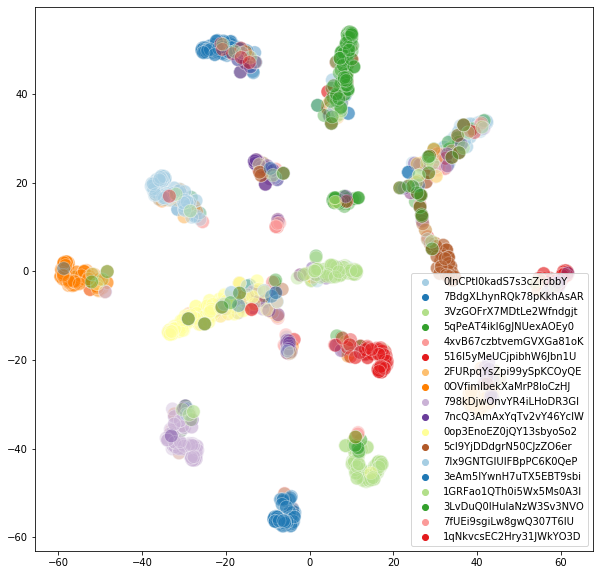

In [274]:
sns.set_palette("Paired", n_colors=20)
plt.figure(figsize=(10,10))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=original_artist, s= 183, alpha = .4,
                palette=sns.color_palette(n_colors=num_artists))

In [181]:
# Free GPU memory
from numba import cuda
cuda.select_device(0)
cuda.close()